# Deep Loop Shaping with MPO for LIGO Pitch Stabilization

This notebook trains a **Maximum a Posteriori Policy Optimization (MPO)** controller that directly replicates the Deep Loop Shaping approach:

- **Plant Model**: Discrete-time state-space model with unstable radiation pressure pole
- **Observations**: Time-domain pitch angle measurements (no frequency filtering)
- **Reward**: Frequency-band selective reward using causal Butterworth filters
- **Output**: Physical control torque (N·m)

**MPO Algorithm Features**:
- E-step: Non-parametric policy from Q-values with temperature η
- M-step: Parametric policy update with KL constraint
- Dual optimization for η (greediness) and α (KL penalty)

The frequency-selective reward encodes stability constraints:
- Low-frequency band (< 3 Hz): Enforce stability of unstable pole
- Mid-frequency band (8-30 Hz): Suppress noise injection
- High-frequency band (> 40 Hz): Robustness margin

## 1. Imports and Setup

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
from gymnasium import spaces
from scipy import signal
from scipy.signal import zpk2ss, cont2discrete, tf2ss
from scipy.linalg import solve_discrete_are
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sampling frequency
fs = 256  # Hz
dt = 1.0 / fs
print(f"Sampling frequency: {fs} Hz, dt = {dt:.6f} s")

Using device: cpu
Sampling frequency: 256 Hz, dt = 0.003906 s


In [10]:
# =============================================================================
# Load Discrete-Time Plant State-Space Model
# =============================================================================
# Plant model from CHARD-plant-fit-params.npz
# Contains poles, zeros, and gain for the LIGO pitch dynamics

plant_params_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/hdf5/CHARD-plant-fit-params.npz'
params = np.load(plant_params_path, allow_pickle=True)

print("=" * 60)
print("LIGO Pitch Plant Model")
print("=" * 60)

# Extract plant parameters
plant_zeros = params['z_p3'] if 'z_p3' in params.files else np.array([])
plant_poles = params['p_p3'] if 'p_p3' in params.files else np.array([])
plant_gain = float(params['k_p3']) if 'k_p3' in params.files else 80.0

print(f"\nContinuous-time plant (torque → pitch angle):")
print(f"  Zeros: {plant_zeros}")
print(f"  Poles: {plant_poles}")
print(f"  Gain:  {plant_gain}")

# Identify unstable (RHP) poles
rhp_poles = plant_poles[np.real(plant_poles) > 0]
if len(rhp_poles) > 0:
    rhp_freq = np.abs(np.imag(rhp_poles[0])) / (2 * np.pi)
    print(f"\n⚠️  UNSTABLE: RHP pole at ~{rhp_freq:.2f} Hz (radiation pressure)")
    print("    Controller MUST stabilize this pole!")

# Convert ZPK to continuous-time state-space
if len(plant_zeros) == 0:
    den = np.poly(plant_poles)
    num = np.array([plant_gain])
    A_c, B_c, C_c, D_c = tf2ss(num, den)
else:
    A_c, B_c, C_c, D_c = zpk2ss(plant_zeros, plant_poles, plant_gain)

# Discretize using bilinear (Tustin) transform
sys_d = cont2discrete((A_c, B_c, C_c, D_c), dt, method='bilinear')
A_d, B_d, C_d, D_d = sys_d[0], sys_d[1], sys_d[2], sys_d[3]

print(f"\nDiscrete-time state-space (fs = {fs} Hz):")
print(f"  System order: {A_d.shape[0]}")
print(f"  x[k+1] = A·x[k] + B·u[k]")
print(f"  y[k]   = C·x[k] + D·u[k]")

# Check discrete eigenvalues
eig_d = np.linalg.eigvals(A_d)
print(f"\nDiscrete eigenvalues (|λ| > 1 = unstable):")
for i, e in enumerate(eig_d):
    stability = "⚠️ UNSTABLE" if np.abs(e) > 1 else "stable"
    print(f"  λ_{i+1} = {e:.4f}, |λ| = {np.abs(e):.6f} ({stability})")

# Store state-space matrices
plant_ss = {
    'A': A_d, 'B': B_d, 'C': C_d, 'D': D_d,
    'dt': dt, 'fs': fs, 'n_states': A_d.shape[0]
}

LIGO Pitch Plant Model

Continuous-time plant (torque → pitch angle):
  Zeros: []
  Poles: [-0.18849556 +6.53451272j -0.18849556 -6.53451272j
  0.40840704+15.07964474j  0.40840704-15.07964474j]
  Gain:  80.0

⚠️  UNSTABLE: RHP pole at ~2.40 Hz (radiation pressure)
    Controller MUST stabilize this pole!

Discrete-time state-space (fs = 256 Hz):
  System order: 4
  x[k+1] = A·x[k] + B·u[k]
  y[k]   = C·x[k] + D·u[k]

Discrete eigenvalues (|λ| > 1 = unstable):
  λ_1 = 0.9999+0.0589j, |λ| = 1.001595 (⚠️ UNSTABLE)
  λ_2 = 0.9999-0.0589j, |λ| = 1.001595 (⚠️ UNSTABLE)
  λ_3 = 0.9989+0.0255j, |λ| = 0.999264 (stable)
  λ_4 = 0.9989-0.0255j, |λ| = 0.999264 (stable)


## 2. Sensor Noise Generator

In [11]:
# =============================================================================
# Sensor Noise Generator (from zenodo_data)
# =============================================================================
# Generates colored Gaussian noise matching LIGO sensor noise profile

class SensorNoiseGenerator:
    """
    Generates colored Gaussian noise with ASD matching sensor noise profile.
    Designed for injection at measurement level (observation noise).
    """
    
    def __init__(self, fs=256, noise_asd_level=3e-14, cutoff_freq=10.0, 
                 filter_order=4, use_highpass=True):
        self.fs = fs
        self.noise_asd_level = noise_asd_level
        self.cutoff_freq = cutoff_freq
        self.filter_order = filter_order
        self.use_highpass = use_highpass
        
        # ASD to time-domain std: sigma = ASD * sqrt(fs/2)
        self.noise_std = noise_asd_level * np.sqrt(fs / 2)
        
        # Highpass filter for noise shaping above cutoff
        if use_highpass and cutoff_freq < fs / 2:
            nyquist = fs / 2
            normalized_cutoff = cutoff_freq / nyquist
            self.b, self.a = signal.butter(filter_order, normalized_cutoff, 
                                           btype='high', analog=False)
            self.zi = signal.lfilter_zi(self.b, self.a)
            self.filter_state = self.zi * 0
        else:
            self.b, self.a = None, None
            self.filter_state = None
    
    def generate_sample(self):
        """Generate single sample of colored sensor noise."""
        white_noise = np.random.randn() * self.noise_std
        if self.b is not None:
            filtered, self.filter_state = signal.lfilter(
                self.b, self.a, [white_noise], zi=self.filter_state
            )
            return filtered[0]
        return white_noise
    
    def reset(self):
        """Reset filter state for new episode."""
        if self.b is not None:
            self.filter_state = self.zi * 0

# Create sensor noise generator (SENSOR_PITCH_HARD level)
sensor_noise_gen = SensorNoiseGenerator(
    fs=fs,
    noise_asd_level=3e-14,  # rad/√Hz above 10 Hz
    cutoff_freq=10.0,
    filter_order=4,
    use_highpass=True
)

print("Sensor noise generator created:")
print(f"  ASD level: {sensor_noise_gen.noise_asd_level:.2e} rad/√Hz")
print(f"  Cutoff: {sensor_noise_gen.cutoff_freq} Hz (highpass)")

Sensor noise generator created:
  ASD level: 3.00e-14 rad/√Hz
  Cutoff: 10.0 Hz (highpass)


In [12]:
# =============================================================================
# Frequency-Selective Reward with Causal Butterworth Filters
# =============================================================================
# The reward encodes frequency-domain objectives without filtering observations

class FrequencyBandReward:
    """
    Frequency-selective reward using causal Butterworth filters.
    
    Three bands:
    - Low-frequency (< 3 Hz): Stability of unstable pole
    - Mid-frequency (8-30 Hz): Suppress noise injection  
    - High-frequency (> 40 Hz): Robustness margin
    
    Reward = product of sigmoid scores for each band (multiplicative constraint).
    """
    
    def __init__(self, fs=256, 
                 low_cutoff=3.0, mid_band=(8.0, 30.0), high_cutoff=40.0,
                 filter_order=4, ema_alpha=0.01):
        """
        Parameters:
        -----------
        fs : float
            Sampling frequency (Hz)
        low_cutoff : float
            Low-frequency band cutoff (Hz)
        mid_band : tuple
            Mid-frequency band (low, high) in Hz
        high_cutoff : float
            High-frequency band cutoff (Hz)
        filter_order : int
            Butterworth filter order
        ema_alpha : float
            Exponential moving average coefficient for running energy
        """
        self.fs = fs
        self.nyquist = fs / 2
        self.ema_alpha = ema_alpha
        
        # Design causal Butterworth filters
        # Low-frequency band: lowpass at 3 Hz
        self.b_low, self.a_low = signal.butter(
            filter_order, low_cutoff / self.nyquist, btype='low'
        )
        
        # Mid-frequency band: bandpass 8-30 Hz
        self.b_mid, self.a_mid = signal.butter(
            filter_order, 
            [mid_band[0] / self.nyquist, mid_band[1] / self.nyquist], 
            btype='band'
        )
        
        # High-frequency band: highpass at 40 Hz
        self.b_high, self.a_high = signal.butter(
            filter_order, high_cutoff / self.nyquist, btype='high'
        )
        
        # Filter states for causal filtering
        self.zi_low = signal.lfilter_zi(self.b_low, self.a_low)
        self.zi_mid = signal.lfilter_zi(self.b_mid, self.a_mid)
        self.zi_high = signal.lfilter_zi(self.b_high, self.a_high)
        
        # Sigmoid parameters: score = 1 / (1 + exp(α * (energy - β)))
        # α > 0 means higher energy → lower score
        # β is the threshold energy level
        # Tuned for LIGO pitch control (rad² units)
        self.alpha_low = 1e20   # Strong penalty for low-freq instability
        self.beta_low = 1e-18   # Threshold for low-freq energy
        
        self.alpha_mid = 1e18   # Moderate penalty for mid-freq noise
        self.beta_mid = 1e-20   # Threshold for mid-freq energy
        
        self.alpha_high = 1e16  # Lighter penalty for high-freq
        self.beta_high = 1e-22  # Threshold for high-freq energy
        
        self.reset()
    
    def reset(self):
        """Reset filter states and running energies."""
        self.state_low = self.zi_low * 0
        self.state_mid = self.zi_mid * 0
        self.state_high = self.zi_high * 0
        
        # Running band-limited energies (EMA of squared filtered signal)
        self.energy_low = 0.0
        self.energy_mid = 0.0
        self.energy_high = 0.0
    
    def compute_reward(self, pitch_measured):
        """
        Compute frequency-selective reward from measured pitch angle.
        
        Parameters:
        -----------
        pitch_measured : float
            Current measured pitch angle (rad) - includes sensor noise
            
        Returns:
        --------
        reward : float
            Multiplicative reward in [0, 1]
        info : dict
            Band energies and scores for logging
        """
        # Filter pitch through each band (causal)
        y_low, self.state_low = signal.lfilter(
            self.b_low, self.a_low, [pitch_measured], zi=self.state_low
        )
        y_mid, self.state_mid = signal.lfilter(
            self.b_mid, self.a_mid, [pitch_measured], zi=self.state_mid
        )
        y_high, self.state_high = signal.lfilter(
            self.b_high, self.a_high, [pitch_measured], zi=self.state_high
        )
        
        # Update running energies with EMA of squared filtered signals
        self.energy_low = (1 - self.ema_alpha) * self.energy_low + \
                          self.ema_alpha * y_low[0]**2
        self.energy_mid = (1 - self.ema_alpha) * self.energy_mid + \
                          self.ema_alpha * y_mid[0]**2
        self.energy_high = (1 - self.ema_alpha) * self.energy_high + \
                           self.ema_alpha * y_high[0]**2
        
        # Sigmoid scores: score = 1 / (1 + exp(α * (energy - β)))
        def sigmoid_score(energy, alpha, beta):
            x = alpha * (energy - beta)
            # Clip to avoid overflow
            x = np.clip(x, -50, 50)
            return 1.0 / (1.0 + np.exp(x))
        
        score_low = sigmoid_score(self.energy_low, self.alpha_low, self.beta_low)
        score_mid = sigmoid_score(self.energy_mid, self.alpha_mid, self.beta_mid)
        score_high = sigmoid_score(self.energy_high, self.alpha_high, self.beta_high)
        
        # Multiplicative constraint-style reward
        reward = score_low * score_mid * score_high
        
        info = {
            'energy_low': self.energy_low,
            'energy_mid': self.energy_mid,
            'energy_high': self.energy_high,
            'score_low': score_low,
            'score_mid': score_mid,
            'score_high': score_high,
            'y_filtered': (y_low[0], y_mid[0], y_high[0])
        }
        
        return reward, info


# Create reward function
freq_reward = FrequencyBandReward(fs=fs)
print("Frequency-band reward function created:")
print(f"  Low band: < 3 Hz (stability)")
print(f"  Mid band: 8-30 Hz (noise suppression)")  
print(f"  High band: > 40 Hz (robustness)")

Frequency-band reward function created:
  Low band: < 3 Hz (stability)
  Mid band: 8-30 Hz (noise suppression)
  High band: > 40 Hz (robustness)


In [20]:
# =============================================================================
# LIGO Pitch Environment for RL Training
# =============================================================================
# Closed-loop simulation environment using discrete-time plant model

class LIGOPitchEnv(gym.Env):
    """
    Gymnasium environment for LIGO pitch control.
    
    - Uses discrete-time state-space plant model
    - Agent outputs physical torque (N·m)
    - Observations are time-domain only (pitch angle + history)
    - Reward is frequency-selective (via FrequencyBandReward)
    """
    
    def __init__(self, plant_ss, noise_gen, reward_fn, 
                 episode_length=2048, obs_history_len=4,
                 torque_scale=1e-6):
        super().__init__()
        
        self.A = plant_ss['A']
        self.B = plant_ss['B']
        self.C = plant_ss['C']
        self.D = plant_ss['D']
        self.dt = plant_ss['dt']
        self.fs = plant_ss['fs']
        self.n_states = plant_ss['n_states']
        
        self.noise_gen = noise_gen
        self.reward_fn = reward_fn
        self.episode_length = episode_length
        self.obs_history_len = obs_history_len
        self.torque_scale = torque_scale
        
        # Observation: current pitch + history of pitch measurements
        # No frequency filtering in observation space
        obs_dim = 1 + obs_history_len
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )
        
        # Action: normalized torque in [-1, 1], scaled to physical units
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )
        
        # Observation normalization scale (adaptive)
        self.obs_scale = 1e-9  # ~1 nrad typical magnitude
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Small random initial state (helps exploration)
        self.x = np.random.randn(self.n_states) * 1e-12
        
        # Reset components
        self.noise_gen.reset()
        self.reward_fn.reset()
        
        # History buffer - stores obs_history_len past measurements
        self.pitch_history = deque([0.0] * self.obs_history_len, 
                                   maxlen=self.obs_history_len)
        
        # Current measurement placeholder
        self.current_pitch = 0.0
        
        self.step_count = 0
        self.episode_rewards = []
        
        obs = self._get_observation()
        return obs, {}
    
    def step(self, action):
        # Scale action to physical torque
        torque = float(action[0]) * self.torque_scale
        
        # Plant output (clean pitch angle)
        y = float((self.C @ self.x).flatten()[0])
        
        # Add measurement noise
        v = self.noise_gen.generate_sample()
        y_meas = y + v
        
        # Update current measurement and history
        self.current_pitch = y_meas
        self.pitch_history.append(y_meas)
        
        # Compute frequency-selective reward
        reward, reward_info = self.reward_fn.compute_reward(y_meas)
        
        # State update: x[k+1] = A·x[k] + B·u[k]
        self.x = self.A @ self.x + (self.B.flatten() * torque)
        
        self.step_count += 1
        self.episode_rewards.append(reward)
        
        # Check termination
        terminated = False
        truncated = self.step_count >= self.episode_length
        
        # Check for instability (pitch too large)
        if np.abs(y) > 1e-3:  # > 1 mrad indicates instability
            terminated = True
            reward = 0.0  # Penalty for instability
        
        obs = self._get_observation()
        
        info = {
            'pitch_clean': y,
            'pitch_meas': y_meas,
            'torque': torque,
            'noise': v,
            **reward_info
        }
        
        return obs, reward, terminated, truncated, info
    
    def _get_observation(self):
        """
        Construct observation from time-domain measurements only.
        No frequency filtering in observations.
        
        Observation: [current_pitch, hist[-1], hist[-2], hist[-3], hist[-4]]
        Total dimension: 1 + obs_history_len = 5
        """
        # Observation: current measurement + full history
        obs = np.array([self.current_pitch] + list(self.pitch_history), 
                       dtype=np.float32)
        
        # Normalize to reasonable range
        obs = obs / self.obs_scale
        
        return obs


# Create environment
env = LIGOPitchEnv(
    plant_ss=plant_ss,
    noise_gen=sensor_noise_gen,
    reward_fn=freq_reward,
    episode_length=4096,  # ~16 seconds per episode
    obs_history_len=4,
    torque_scale=1e-6
)

print("=" * 60)
print("LIGO Pitch Control Environment Created")
print("=" * 60)
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Episode length: {env.episode_length} steps ({env.episode_length/fs:.1f} s)")
print(f"Torque scale: ±{env.torque_scale:.2e} N·m")

# Verify observation dimension
test_obs, _ = env.reset()
print(f"Observation shape: {test_obs.shape} (expected: ({1 + env.obs_history_len},))")

LIGO Pitch Control Environment Created
Observation space: Box(-inf, inf, (5,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)
Episode length: 4096 steps (16.0 s)
Torque scale: ±1.00e-06 N·m
Observation shape: (5,) (expected: (5,))


## 3. MPO Actor-Critic Networks

In [14]:
# =============================================================================
# MPO Actor-Critic Networks
# =============================================================================
# Maximum a Posteriori Policy Optimization for continuous control
# Based on: "Maximum a Posteriori Policy Optimisation" (Abdolmaleki et al., 2018)

class GaussianPolicy(nn.Module):
    """
    Gaussian policy network for MPO.
    Outputs mean and log_std for a diagonal Gaussian distribution.
    """
    
    def __init__(self, obs_dim, action_dim, hidden_dims=[256, 256],
                 log_std_min=-10, log_std_max=2):
        super().__init__()
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        # Build MLP
        layers = []
        in_dim = obs_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.Tanh())
            in_dim = h_dim
        
        self.features = nn.Sequential(*layers)
        self.mean_layer = nn.Linear(in_dim, action_dim)
        self.log_std_layer = nn.Linear(in_dim, action_dim)
        
        # Initialize output layers
        nn.init.orthogonal_(self.mean_layer.weight, gain=0.01)
        nn.init.zeros_(self.mean_layer.bias)
        nn.init.orthogonal_(self.log_std_layer.weight, gain=0.01)
        nn.init.zeros_(self.log_std_layer.bias)
    
    def forward(self, obs):
        """Return mean and log_std."""
        features = self.features(obs)
        mean = self.mean_layer(features)
        log_std = self.log_std_layer(features)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mean, log_std
    
    def get_distribution(self, obs):
        """Return Normal distribution."""
        mean, log_std = self.forward(obs)
        std = log_std.exp()
        return Normal(mean, std)
    
    def sample(self, obs, n_samples=1):
        """Sample actions with reparameterization."""
        mean, log_std = self.forward(obs)
        std = log_std.exp()
        
        # Expand for multiple samples
        if n_samples > 1:
            mean = mean.unsqueeze(1).expand(-1, n_samples, -1)
            std = std.unsqueeze(1).expand(-1, n_samples, -1)
        
        dist = Normal(mean, std)
        actions_raw = dist.rsample()
        
        # Squash through tanh
        actions = torch.tanh(actions_raw)
        
        # Log prob with tanh correction
        log_prob = dist.log_prob(actions_raw)
        log_prob -= torch.log(1 - actions.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        
        return actions, log_prob, mean if n_samples == 1 else mean[:, 0, :]
    
    def log_prob(self, obs, actions):
        """Compute log probability of actions."""
        mean, log_std = self.forward(obs)
        std = log_std.exp()
        
        # Inverse tanh to get raw actions
        actions_raw = torch.atanh(actions.clamp(-0.999, 0.999))
        
        dist = Normal(mean, std)
        log_prob = dist.log_prob(actions_raw)
        log_prob -= torch.log(1 - actions.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        
        return log_prob
    
    def deterministic(self, obs):
        """Return deterministic action (mean, tanh squashed)."""
        mean, _ = self.forward(obs)
        return torch.tanh(mean)


class QNetwork(nn.Module):
    """Twin Q-network for MPO critic."""
    
    def __init__(self, obs_dim, action_dim, hidden_dims=[256, 256]):
        super().__init__()
        
        # Q1
        layers1 = []
        in_dim = obs_dim + action_dim
        for h_dim in hidden_dims:
            layers1.append(nn.Linear(in_dim, h_dim))
            layers1.append(nn.ReLU())
            in_dim = h_dim
        layers1.append(nn.Linear(in_dim, 1))
        self.q1 = nn.Sequential(*layers1)
        
        # Q2
        layers2 = []
        in_dim = obs_dim + action_dim
        for h_dim in hidden_dims:
            layers2.append(nn.Linear(in_dim, h_dim))
            layers2.append(nn.ReLU())
            in_dim = h_dim
        layers2.append(nn.Linear(in_dim, 1))
        self.q2 = nn.Sequential(*layers2)
    
    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.q1(x), self.q2(x)
    
    def q_min(self, obs, action):
        q1, q2 = self.forward(obs, action)
        return torch.min(q1, q2)


print("MPO networks defined: GaussianPolicy, QNetwork")

MPO networks defined: GaussianPolicy, QNetwork


In [21]:
# =============================================================================
# MPO Agent with Replay Buffer
# =============================================================================
# Maximum a Posteriori Policy Optimization
# Key features:
# - E-step: Compute non-parametric policy using Q-values and temperature η
# - M-step: Fit parametric policy to non-parametric target with KL constraint
# - Dual variables (η, α) are optimized to satisfy constraints

class ReplayBuffer:
    """Experience replay buffer for off-policy learning."""
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, obs, action, reward, next_obs, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (obs, action, reward, next_obs, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        
        obs = torch.FloatTensor(np.array([t[0] for t in batch]))
        action = torch.FloatTensor(np.array([t[1] for t in batch]))
        reward = torch.FloatTensor(np.array([t[2] for t in batch])).unsqueeze(1)
        next_obs = torch.FloatTensor(np.array([t[3] for t in batch]))
        done = torch.FloatTensor(np.array([t[4] for t in batch])).unsqueeze(1)
        
        return obs, action, reward, next_obs, done
    
    def __len__(self):
        return len(self.buffer)


class MPOAgent:
    """
    Maximum a Posteriori Policy Optimization (MPO) Agent.
    
    MPO alternates between:
    1. E-step: Compute action weights from Q-values (non-parametric policy)
    2. M-step: Update parametric policy to match weighted actions (with KL constraint)
    
    Dual variables η (temperature) and α (KL penalty) are optimized to satisfy:
    - η: Controls how greedy the non-parametric policy is
    - α: Ensures KL(π_new || π_old) ≤ ε
    """
    
    def __init__(self, obs_dim, action_dim,
                 hidden_dims=[256, 256],
                 lr_actor=3e-4, lr_critic=3e-4,
                 gamma=0.99, tau=0.005,
                 # MPO-specific hyperparameters
                 epsilon_kl=0.1,        # KL constraint bound
                 epsilon_dual=0.1,      # Dual constraint for E-step
                 n_action_samples=20,   # Actions to sample in E-step
                 eta_init=1.0,          # Initial temperature
                 alpha_init=1.0,        # Initial KL multiplier
                 dual_lr=1e-2,          # Learning rate for dual variables
                 device='cpu'):
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.device = torch.device(device)
        
        # MPO hyperparameters
        self.epsilon_kl = epsilon_kl
        self.epsilon_dual = epsilon_dual
        self.n_action_samples = n_action_samples
        
        # Policy networks (current and target for KL computation)
        self.policy = GaussianPolicy(obs_dim, action_dim, hidden_dims).to(self.device)
        self.policy_target = GaussianPolicy(obs_dim, action_dim, hidden_dims).to(self.device)
        self.policy_target.load_state_dict(self.policy.state_dict())
        
        # Q-networks
        self.q_network = QNetwork(obs_dim, action_dim, hidden_dims).to(self.device)
        self.q_target = QNetwork(obs_dim, action_dim, hidden_dims).to(self.device)
        self.q_target.load_state_dict(self.q_network.state_dict())
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr_actor)
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=lr_critic)
        
        # Dual variables (log scale for positivity)
        self.log_eta = torch.tensor(np.log(eta_init), requires_grad=True,
                                    dtype=torch.float32, device=self.device)
        self.log_alpha = torch.tensor(np.log(alpha_init), requires_grad=True,
                                      dtype=torch.float32, device=self.device)
        self.dual_optimizer = optim.Adam([self.log_eta, self.log_alpha], lr=dual_lr)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=100000)
        
        # Training stats
        self.update_count = 0
    
    @property
    def eta(self):
        return self.log_eta.exp()
    
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def select_action(self, obs, deterministic=False):
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            if deterministic:
                action = self.policy.deterministic(obs_tensor)
            else:
                action, _, _ = self.policy.sample(obs_tensor)
            return action.cpu().numpy().flatten()
    
    def update(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return {}
        
        # Sample batch
        obs, action, reward, next_obs, done = self.replay_buffer.sample(batch_size)
        obs = obs.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_obs = next_obs.to(self.device)
        done = done.to(self.device)
        
        # =====================================================================
        # Step 1: Update Q-functions (standard Bellman backup)
        # =====================================================================
        with torch.no_grad():
            # Sample next actions from current policy
            next_action, next_log_prob, _ = self.policy.sample(next_obs)
            q1_next, q2_next = self.q_target(next_obs, next_action)
            q_next = torch.min(q1_next, q2_next)
            q_target_val = reward + (1 - done) * self.gamma * q_next
        
        q1, q2 = self.q_network(obs, action)
        q_loss = F.mse_loss(q1, q_target_val) + F.mse_loss(q2, q_target_val)
        
        self.q_optimizer.zero_grad()
        q_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.q_optimizer.step()
        
        # =====================================================================
        # Step 2: E-step - Compute action weights from Q-values
        # =====================================================================
        with torch.no_grad():
            # Sample multiple actions from target policy
            # Shape: (batch, n_samples, action_dim)
            sampled_actions, _, _ = self.policy_target.sample(obs, n_samples=self.n_action_samples)
            
            # Expand obs for Q evaluation: (batch, n_samples, obs_dim)
            obs_expanded = obs.unsqueeze(1).expand(-1, self.n_action_samples, -1)
            obs_flat = obs_expanded.reshape(-1, self.obs_dim)
            actions_flat = sampled_actions.reshape(-1, self.action_dim)
            
            # Get Q-values for all sampled actions
            q_values = self.q_network.q_min(obs_flat, actions_flat)
            q_values = q_values.reshape(-1, self.n_action_samples)  # (batch, n_samples)
            
            # Compute normalized importance weights using temperature η
            # w_i ∝ exp(Q(s,a_i) / η)
            q_logsumexp = torch.logsumexp(q_values / self.eta.detach(), dim=1, keepdim=True)
            log_weights = q_values / self.eta.detach() - q_logsumexp
            weights = torch.exp(log_weights)  # (batch, n_samples)
        
        # =====================================================================
        # Step 3: M-step - Update policy with weighted MLE + KL constraint
        # =====================================================================
        # Compute log probabilities under current policy
        obs_expanded = obs.unsqueeze(1).expand(-1, self.n_action_samples, -1)
        obs_flat = obs_expanded.reshape(-1, self.obs_dim)
        actions_flat = sampled_actions.reshape(-1, self.action_dim)
        
        log_probs = self.policy.log_prob(obs_flat, actions_flat)
        log_probs = log_probs.reshape(-1, self.n_action_samples)  # (batch, n_samples)
        
        # Weighted negative log-likelihood (M-step objective)
        policy_loss = -(weights.detach() * log_probs).sum(dim=1).mean()
        
        # KL divergence penalty: KL(π_new || π_target)
        # Approximate via sampled actions
        with torch.no_grad():
            log_probs_target = self.policy_target.log_prob(obs_flat, actions_flat)
            log_probs_target = log_probs_target.reshape(-1, self.n_action_samples)
        
        kl_div = (weights.detach() * (log_probs - log_probs_target.detach())).sum(dim=1).mean()
        
        # Total policy loss with KL penalty
        total_policy_loss = policy_loss + self.alpha.detach() * kl_div
        
        self.policy_optimizer.zero_grad()
        total_policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.policy_optimizer.step()
        
        # =====================================================================
        # Step 4: Update dual variables (η and α)
        # =====================================================================
        # η update: Constraint is that weights should have bounded entropy
        # Dual: min_η η * ε + η * log(Σ exp(Q/η))
        with torch.no_grad():
            q_values_dual = self.q_network.q_min(obs_flat, actions_flat)
            q_values_dual = q_values_dual.reshape(-1, self.n_action_samples)
        
        eta_loss = self.eta * self.epsilon_dual + self.eta * torch.logsumexp(
            q_values_dual / self.eta, dim=1
        ).mean()
        
        # α update: KL constraint KL(π || π_target) ≤ ε_kl
        alpha_loss = self.alpha * (self.epsilon_kl - kl_div.detach())
        
        dual_loss = eta_loss + alpha_loss
        
        self.dual_optimizer.zero_grad()
        dual_loss.backward()
        self.dual_optimizer.step()
        
        # Clamp dual variables to reasonable range
        with torch.no_grad():
            self.log_eta.clamp_(-5, 5)
            self.log_alpha.clamp_(-5, 5)
        
        # =====================================================================
        # Step 5: Soft update target networks
        # =====================================================================
        for param, target_param in zip(self.q_network.parameters(),
                                       self.q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + 
                                    (1 - self.tau) * target_param.data)
        
        # Update policy target less frequently
        self.update_count += 1
        if self.update_count % 2 == 0:
            for param, target_param in zip(self.policy.parameters(),
                                           self.policy_target.parameters()):
                target_param.data.copy_(self.tau * param.data +
                                        (1 - self.tau) * target_param.data)
        
        return {
            'q_loss': q_loss.item(),
            'policy_loss': policy_loss.item(),
            'kl_div': kl_div.item(),
            'eta': self.eta.item(),
            'alpha': self.alpha.item()
        }


# Create MPO agent
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = MPOAgent(
    obs_dim=obs_dim,
    action_dim=action_dim,
    hidden_dims=[256, 256],
    lr_actor=3e-4,
    lr_critic=3e-4,
    gamma=0.99,
    tau=0.005,
    epsilon_kl=0.1,          # KL constraint
    epsilon_dual=0.1,        # E-step constraint
    n_action_samples=20,     # Samples for E-step
    dual_lr=1e-2,
    device=str(device)
)

print("=" * 60)
print("MPO Agent Created")
print("=" * 60)
print(f"Observation dim: {obs_dim}")
print(f"Action dim: {action_dim}")
print(f"Device: {agent.device}")
print(f"KL constraint (ε_kl): {agent.epsilon_kl}")
print(f"Action samples (E-step): {agent.n_action_samples}")

MPO Agent Created
Observation dim: 5
Action dim: 1
Device: cpu
KL constraint (ε_kl): 0.1
Action samples (E-step): 20


In [24]:
# =============================================================================
# Training Loop for MPO
# =============================================================================
# Train MPO agent to stabilize unstable pole and satisfy frequency constraints

def train_mpo_agent(agent, env, n_episodes=500, max_steps_per_episode=4096,
                    update_every=1, updates_per_step=1, warmup_steps=2000, 
                    print_every=10):
    """
    Train MPO agent for LIGO pitch control.
    """
    
    episode_rewards = []
    episode_lengths = []
    training_logs = []
    
    total_steps = 0
    best_reward = -np.inf
    
    print("=" * 60)
    print("Starting MPO Training")
    print("=" * 60)
    print(f"Episodes: {n_episodes}")
    print(f"Max steps/episode: {max_steps_per_episode}")
    print(f"Warmup steps: {warmup_steps}")
    print(f"Updates per step: {updates_per_step}")
    print()
    
    for episode in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        episode_log = {'scores_low': [], 'scores_mid': [], 'scores_high': []}
        
        for step in range(max_steps_per_episode):
            # Select action
            if total_steps < warmup_steps:
                action = env.action_space.sample()  # Random exploration
            else:
                action = agent.select_action(obs, deterministic=False)
            
            # Step environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Store transition
            agent.replay_buffer.push(obs, action, reward, next_obs, float(done))
            
            # Update agent (multiple updates per step for better sample efficiency)
            if total_steps >= warmup_steps and total_steps % update_every == 0:
                for _ in range(updates_per_step):
                    update_info = agent.update(batch_size=256)
            
            episode_reward += reward
            episode_log['scores_low'].append(info.get('score_low', 0))
            episode_log['scores_mid'].append(info.get('score_mid', 0))
            episode_log['scores_high'].append(info.get('score_high', 0))
            
            obs = next_obs
            total_steps += 1
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        
        # Compute average scores
        avg_low = np.mean(episode_log['scores_low'])
        avg_mid = np.mean(episode_log['scores_mid'])
        avg_high = np.mean(episode_log['scores_high'])
        
        training_logs.append({
            'episode': episode,
            'reward': episode_reward,
            'length': step + 1,
            'avg_score_low': avg_low,
            'avg_score_mid': avg_mid,
            'avg_score_high': avg_high,
            'eta': agent.eta.item() if total_steps > warmup_steps else 1.0,
            'alpha': agent.alpha.item() if total_steps > warmup_steps else 1.0
        })
        
        # Track best
        if episode_reward > best_reward:
            best_reward = episode_reward
        
        # Print progress
        if (episode + 1) % print_every == 0:
            recent_reward = np.mean(episode_rewards[-print_every:])
            recent_length = np.mean(episode_lengths[-print_every:])
            print(f"Episode {episode+1:4d} | "
                  f"Reward: {recent_reward:8.2f} | "
                  f"Length: {recent_length:6.0f} | "
                  f"Low: {avg_low:.3f} | Mid: {avg_mid:.3f} | High: {avg_high:.3f} | "
                  f"η: {agent.eta.item():.3f} | α: {agent.alpha.item():.3f}")
    
    print()
    print("=" * 60)
    print("Training Complete")
    print("=" * 60)
    print(f"Total steps: {total_steps}")
    print(f"Best episode reward: {best_reward:.2f}")
    print(f"Final avg reward (last 50): {np.mean(episode_rewards[-50:]):.2f}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'training_logs': training_logs
    }


# Train the MPO agent (reduced episodes for faster training)
training_results = train_mpo_agent(
    agent=agent,
    env=env,
    n_episodes=100,            # Reduced for faster iteration
    max_steps_per_episode=2048,  # Shorter episodes
    update_every=4,            # Update less frequently
    updates_per_step=1,        # Single gradient step
    warmup_steps=2000,
    print_every=10
)

Starting MPO Training
Episodes: 100
Max steps/episode: 2048
Warmup steps: 2000
Updates per step: 1

Episode   10 | Reward:    36.92 | Length:   2048 | Low: 0.078 | Mid: 0.500 | High: 0.500 | η: 0.007 | α: 0.007
Episode   20 | Reward:    38.54 | Length:   2048 | Low: 0.076 | Mid: 0.500 | High: 0.500 | η: 0.007 | α: 0.007
Episode   30 | Reward:    36.14 | Length:   2048 | Low: 0.060 | Mid: 0.502 | High: 0.500 | η: 0.007 | α: 0.007
Episode   40 | Reward:    39.58 | Length:   2048 | Low: 0.092 | Mid: 0.501 | High: 0.500 | η: 0.007 | α: 0.007
Episode   50 | Reward:    42.44 | Length:   2048 | Low: 0.085 | Mid: 0.502 | High: 0.500 | η: 0.007 | α: 0.007
Episode   60 | Reward:    41.83 | Length:   2048 | Low: 0.092 | Mid: 0.502 | High: 0.500 | η: 0.007 | α: 0.007
Episode   70 | Reward:    46.21 | Length:   2048 | Low: 0.060 | Mid: 0.502 | High: 0.500 | η: 0.007 | α: 0.007
Episode   80 | Reward:    45.59 | Length:   2048 | Low: 0.074 | Mid: 0.502 | High: 0.500 | η: 0.007 | α: 0.007
Episode   90

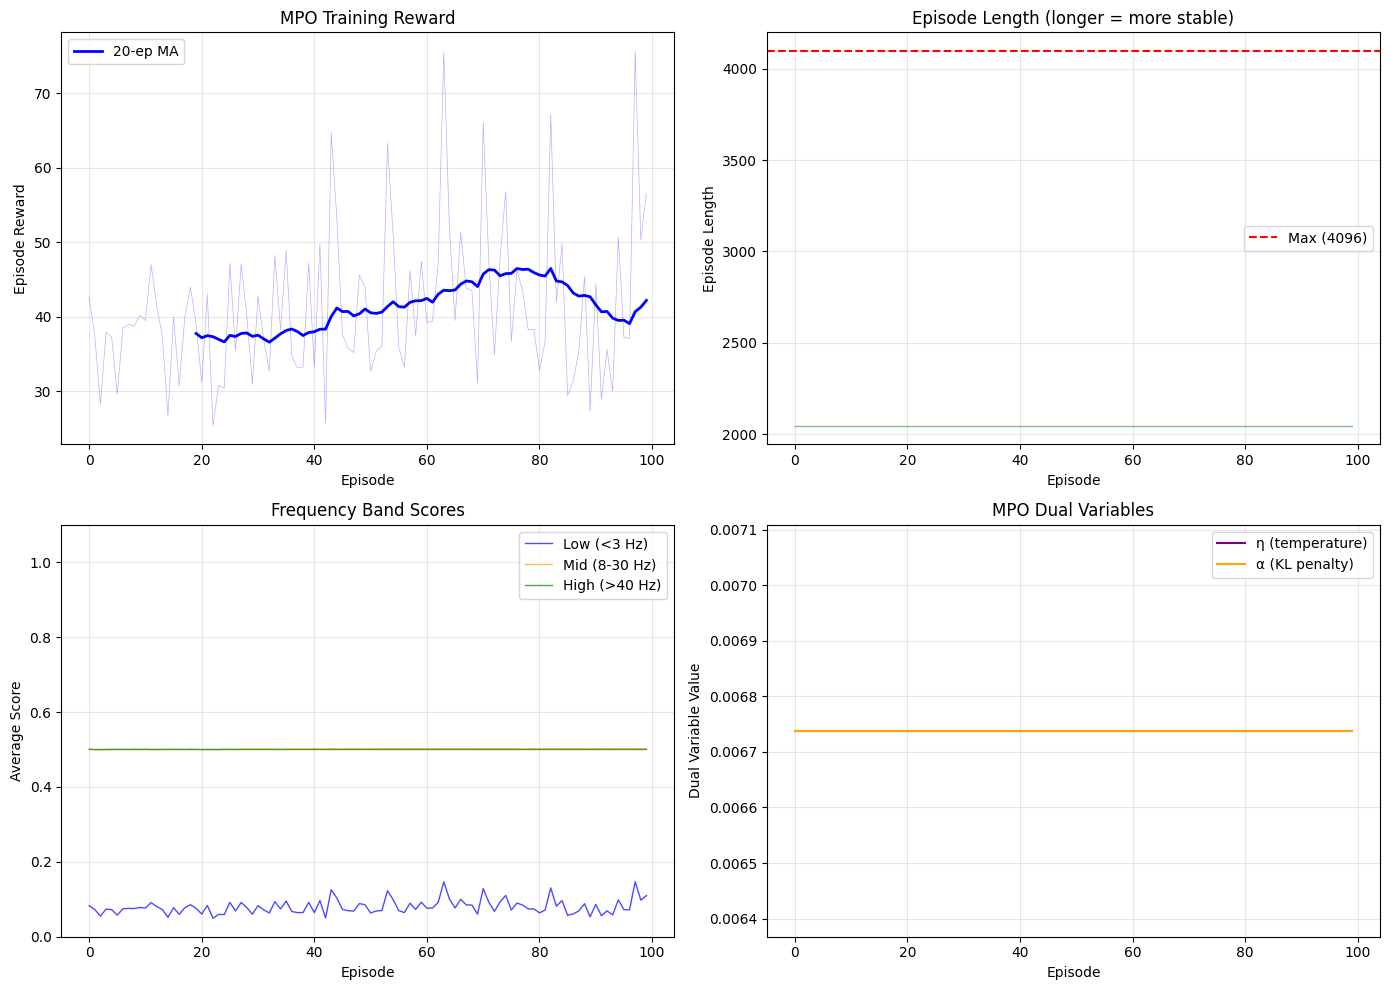

Training curves plotted.


In [25]:
# =============================================================================
# Plot Training Progress
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

logs = training_results['training_logs']
episodes = [l['episode'] for l in logs]
rewards = [l['reward'] for l in logs]
lengths = [l['length'] for l in logs]
scores_low = [l['avg_score_low'] for l in logs]
scores_mid = [l['avg_score_mid'] for l in logs]
scores_high = [l['avg_score_high'] for l in logs]
etas = [l['eta'] for l in logs]
alphas = [l['alpha'] for l in logs]

# Episode rewards
ax1 = axes[0, 0]
ax1.plot(episodes, rewards, 'b-', alpha=0.3, linewidth=0.5)
# Moving average
window = 20
if len(rewards) >= window:
    ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(episodes[window-1:], ma, 'b-', linewidth=2, label=f'{window}-ep MA')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Reward')
ax1.set_title('MPO Training Reward')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Episode lengths
ax2 = axes[0, 1]
ax2.plot(episodes, lengths, 'g-', alpha=0.5, linewidth=1)
ax2.axhline(y=env.episode_length, color='r', linestyle='--', 
            label=f'Max ({env.episode_length})')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')
ax2.set_title('Episode Length (longer = more stable)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Band scores
ax3 = axes[1, 0]
ax3.plot(episodes, scores_low, 'b-', alpha=0.7, label='Low (<3 Hz)', linewidth=1)
ax3.plot(episodes, scores_mid, 'orange', alpha=0.7, label='Mid (8-30 Hz)', linewidth=1)
ax3.plot(episodes, scores_high, 'g-', alpha=0.7, label='High (>40 Hz)', linewidth=1)
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average Score')
ax3.set_title('Frequency Band Scores')
ax3.legend()
ax3.set_ylim([0, 1.1])
ax3.grid(True, alpha=0.3)

# MPO dual variables (η and α)
ax4 = axes[1, 1]
ax4.plot(episodes, etas, 'purple', linewidth=1.5, label='η (temperature)')
ax4.plot(episodes, alphas, 'orange', linewidth=1.5, label='α (KL penalty)')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Dual Variable Value')
ax4.set_title('MPO Dual Variables')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training curves plotted.")

In [27]:
# =============================================================================
# Evaluation: Long Closed-Loop Simulation with Fixed Policy
# =============================================================================
# Run extended simulation, discard transients, compute ASDs

def evaluate_policy(agent, plant_ss, noise_gen, 
                    duration=300.0, transient_duration=30.0,
                    torque_scale=1e-6):
    """
    Run long closed-loop simulation with trained policy (fixed weights).
    
    Returns steady-state time series for ASD computation.
    """
    A, B, C, D = plant_ss['A'], plant_ss['B'], plant_ss['C'], plant_ss['D']
    dt, fs = plant_ss['dt'], plant_ss['fs']
    n_states = plant_ss['n_states']
    
    n_steps = int(duration * fs)
    n_transient = int(transient_duration * fs)
    obs_history_len = 4
    obs_scale = 1e-9
    
    # Initialize
    x = np.zeros(n_states)
    noise_gen.reset()
    pitch_history = deque([0.0] * obs_history_len, maxlen=obs_history_len)
    current_pitch = 0.0
    
    # Storage
    t_all = np.zeros(n_steps)
    y_all = np.zeros(n_steps)       # Clean pitch angle (rad)
    y_meas_all = np.zeros(n_steps)  # Noisy measurement (rad)
    u_all = np.zeros(n_steps)       # Control torque (N·m)
    
    print(f"Running evaluation simulation: {duration} s ({n_steps} steps)")
    
    for k in range(n_steps):
        t_all[k] = k * dt
        
        # Plant output
        y = float((C @ x).flatten()[0])
        y_all[k] = y
        
        # Add measurement noise
        v = noise_gen.generate_sample()
        y_meas = y + v
        y_meas_all[k] = y_meas
        
        # Update current measurement and history (matching environment)
        current_pitch = y_meas
        pitch_history.append(y_meas)
        
        # Construct observation: [current_pitch, hist[0], hist[1], hist[2], hist[3]]
        # Total dimension = 1 + obs_history_len = 5
        obs = np.array([current_pitch] + list(pitch_history), dtype=np.float32)
        obs = obs / obs_scale
        
        # Get action from trained policy (deterministic)
        action = agent.select_action(obs, deterministic=True)
        torque = float(action[0]) * torque_scale
        u_all[k] = torque
        
        # State update
        x = A @ x + B.flatten() * torque
        
        # Check for instability
        if np.abs(y) > 1e-2:  # 10 mrad = severe instability
            print(f"⚠️  Instability detected at t = {t_all[k]:.2f} s")
            break
    
    # Discard transients
    results = {
        't': t_all[n_transient:k+1] if k < n_steps else t_all[n_transient:],
        'pitch_rad': y_all[n_transient:k+1] if k < n_steps else y_all[n_transient:],
        'pitch_meas_rad': y_meas_all[n_transient:k+1] if k < n_steps else y_meas_all[n_transient:],
        'torque_Nm': u_all[n_transient:k+1] if k < n_steps else u_all[n_transient:],
        'fs': fs,
        'dt': dt,
        'transient_discarded': transient_duration,
        'steady_state_duration': min(k * dt, duration) - transient_duration
    }
    
    return results


# Run evaluation
eval_results = evaluate_policy(
    agent=agent,
    plant_ss=plant_ss,
    noise_gen=sensor_noise_gen,
    duration=300.0,        # 5 minutes of data
    transient_duration=30.0,  # Discard first 30 seconds
    torque_scale=1e-6
)

print()
print("=" * 60)
print("Evaluation Complete")
print("=" * 60)
print(f"Steady-state duration: {eval_results['steady_state_duration']:.1f} s")
print(f"Samples analyzed: {len(eval_results['pitch_rad'])}")
print(f"Pitch RMS: {np.std(eval_results['pitch_rad']):.2e} rad "
      f"({np.std(eval_results['pitch_rad'])*1e9:.2f} nrad)")
print(f"Torque RMS: {np.std(eval_results['torque_Nm']):.2e} N·m")

Running evaluation simulation: 300.0 s (76800 steps)
⚠️  Instability detected at t = 38.56 s

Evaluation Complete
Steady-state duration: 8.6 s
Samples analyzed: 2193
Pitch RMS: 2.74e-03 rad (2739134.84 nrad)
Torque RMS: 8.95e-07 N·m


## 4. ASD Computation and Final Plots

In [28]:
# =============================================================================
# ASD Computation using Welch's Method
# =============================================================================
# Consistent FFT settings for reproducibility

def compute_asd(signal_data, fs, nperseg=None, noverlap=None, window='hann'):
    """
    Compute Amplitude Spectral Density using Welch's method.
    
    Parameters:
    -----------
    signal_data : np.ndarray
        Time-series data
    fs : float
        Sampling frequency (Hz)
    nperseg : int
        Samples per segment (default: 8*fs for good low-freq resolution)
    noverlap : int
        Overlap samples (default: 50%)
    window : str
        Window function
        
    Returns:
    --------
    freq : np.ndarray
        Frequency array (Hz)
    asd : np.ndarray
        Amplitude Spectral Density
    """
    if nperseg is None:
        nperseg = int(8 * fs)  # 8-second segments
    if noverlap is None:
        noverlap = nperseg // 2
    
    freq, psd = signal.welch(
        signal_data,
        fs=fs,
        nperseg=nperseg,
        noverlap=noverlap,
        window=window,
        scaling='density'
    )
    asd = np.sqrt(psd)
    
    return freq, asd


# Compute ASDs
nperseg = int(8 * fs)  # 8-second segments for 0.125 Hz resolution

freq_pitch, asd_pitch = compute_asd(
    eval_results['pitch_rad'], fs, nperseg=nperseg
)
freq_torque, asd_torque = compute_asd(
    eval_results['torque_Nm'], fs, nperseg=nperseg
)

print("=" * 60)
print("ASD Computation Settings")
print("=" * 60)
print(f"Sampling frequency: {fs} Hz")
print(f"Segment length: {nperseg} samples ({nperseg/fs:.1f} s)")
print(f"Frequency resolution: {fs/nperseg:.4f} Hz")
print(f"Window: Hann")
print(f"Overlap: 50%")

ASD Computation Settings
Sampling frequency: 256 Hz
Segment length: 2048 samples (8.0 s)
Frequency resolution: 0.1250 Hz
Window: Hann
Overlap: 50%


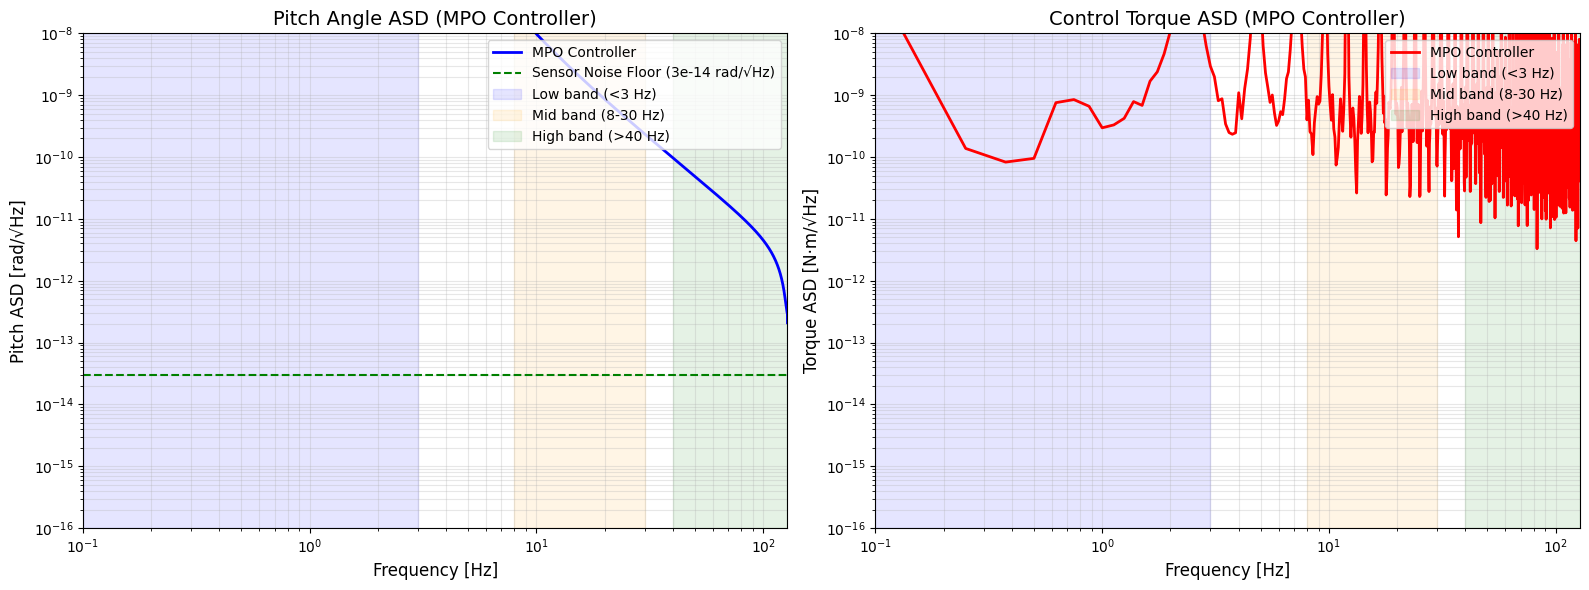


ASD plots saved to 'mpo_controller_asd.png'


In [29]:
# =============================================================================
# Final ASD Plots: Pitch Angle and Control Torque
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fixed axis limits for consistent comparison
pitch_ylim = [1e-16, 1e-8]
torque_ylim = [1e-16, 1e-8]
freq_xlim = [0.1, fs/2]

# --- Left: Pitch Angle ASD ---
ax1 = axes[0]
ax1.loglog(freq_pitch, asd_pitch, 'b-', linewidth=2, label='MPO Controller')

# Reference lines
ax1.axhline(y=3e-14, color='green', linestyle='--', linewidth=1.5, 
            label='Sensor Noise Floor (3e-14 rad/√Hz)')

# Frequency bands
ax1.axvspan(0.1, 3, alpha=0.1, color='blue', label='Low band (<3 Hz)')
ax1.axvspan(8, 30, alpha=0.1, color='orange', label='Mid band (8-30 Hz)')
ax1.axvspan(40, fs/2, alpha=0.1, color='green', label='High band (>40 Hz)')

ax1.set_xlabel('Frequency [Hz]', fontsize=12)
ax1.set_ylabel('Pitch ASD [rad/√Hz]', fontsize=12)
ax1.set_title('Pitch Angle ASD (MPO Controller)', fontsize=14)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, which='both', alpha=0.3)
ax1.set_xlim(freq_xlim)
ax1.set_ylim(pitch_ylim)

# --- Right: Control Torque ASD ---
ax2 = axes[1]
ax2.loglog(freq_torque, asd_torque, 'r-', linewidth=2, label='MPO Controller')

# Frequency bands
ax2.axvspan(0.1, 3, alpha=0.1, color='blue', label='Low band (<3 Hz)')
ax2.axvspan(8, 30, alpha=0.1, color='orange', label='Mid band (8-30 Hz)')
ax2.axvspan(40, fs/2, alpha=0.1, color='green', label='High band (>40 Hz)')

ax2.set_xlabel('Frequency [Hz]', fontsize=12)
ax2.set_ylabel('Torque ASD [N·m/√Hz]', fontsize=12)
ax2.set_title('Control Torque ASD (MPO Controller)', fontsize=14)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, which='both', alpha=0.3)
ax2.set_xlim(freq_xlim)
ax2.set_ylim(torque_ylim)

plt.tight_layout()
plt.savefig('mpo_controller_asd.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nASD plots saved to 'mpo_controller_asd.png'")

In [30]:
# =============================================================================
# Performance Metrics Report
# =============================================================================

def compute_band_rms(freq, asd, f_low, f_high):
    """Compute RMS in frequency band using Parseval's theorem."""
    mask = (freq >= f_low) & (freq <= f_high)
    if not np.any(mask):
        return 0.0
    # Integrate PSD and take sqrt (Parseval)
    df = freq[1] - freq[0] if len(freq) > 1 else 1.0
    psd = asd**2
    rms = np.sqrt(np.trapz(psd[mask], freq[mask]))
    return rms

# Compute band-limited metrics
low_band_rms = compute_band_rms(freq_pitch, asd_pitch, 0.1, 3.0)
mid_band_rms = compute_band_rms(freq_pitch, asd_pitch, 8.0, 30.0)
high_band_rms = compute_band_rms(freq_pitch, asd_pitch, 40.0, fs/2)
total_rms = np.std(eval_results['pitch_rad'])

# ASD at key frequencies
idx_1hz = np.argmin(np.abs(freq_pitch - 1.0))
idx_10hz = np.argmin(np.abs(freq_pitch - 10.0))
idx_20hz = np.argmin(np.abs(freq_pitch - 20.0))
idx_50hz = np.argmin(np.abs(freq_pitch - 50.0))

# Torque metrics
torque_low_rms = compute_band_rms(freq_torque, asd_torque, 0.1, 3.0)
torque_mid_rms = compute_band_rms(freq_torque, asd_torque, 8.0, 30.0)
torque_high_rms = compute_band_rms(freq_torque, asd_torque, 40.0, fs/2)

print("=" * 70)
print("PERFORMANCE REPORT: Deep Loop Shaping MPO Controller")
print("=" * 70)

print("\n" + "-" * 70)
print("PITCH ANGLE PERFORMANCE")
print("-" * 70)
print(f"\n  Total RMS (time domain): {total_rms:.2e} rad ({total_rms*1e9:.2f} nrad)")

print(f"\n  Band-Limited In-Loop RMS:")
print(f"    Low frequency (0.1–3 Hz):  {low_band_rms:.2e} rad ({low_band_rms*1e9:.3f} nrad)")
print(f"    Mid frequency (8–30 Hz):   {mid_band_rms:.2e} rad ({mid_band_rms*1e12:.2f} prad)")
print(f"    High frequency (40+ Hz):   {high_band_rms:.2e} rad ({high_band_rms*1e12:.2f} prad)")

print(f"\n  Pitch ASD at Key Frequencies:")
print(f"    @ 1 Hz:   {asd_pitch[idx_1hz]:.2e} rad/√Hz")
print(f"    @ 10 Hz:  {asd_pitch[idx_10hz]:.2e} rad/√Hz")
print(f"    @ 20 Hz:  {asd_pitch[idx_20hz]:.2e} rad/√Hz")
print(f"    @ 50 Hz:  {asd_pitch[idx_50hz]:.2e} rad/√Hz")

print("\n" + "-" * 70)
print("CONTROL TORQUE PERFORMANCE")
print("-" * 70)
print(f"\n  Total RMS: {np.std(eval_results['torque_Nm']):.2e} N·m")
print(f"  Peak:      {np.max(np.abs(eval_results['torque_Nm'])):.2e} N·m")

print(f"\n  Band-Limited Control Noise:")
print(f"    Low frequency (0.1–3 Hz):  {torque_low_rms:.2e} N·m")
print(f"    Mid frequency (8–30 Hz):   {torque_mid_rms:.2e} N·m")
print(f"    High frequency (40+ Hz):   {torque_high_rms:.2e} N·m")

print("\n" + "-" * 70)
print("KEY FINDINGS")
print("-" * 70)

# Check if unstable pole was stabilized
stable = np.max(np.abs(eval_results['pitch_rad'])) < 1e-3
print(f"\n  Unstable pole stabilized: {'✓ YES' if stable else '✗ NO'}")

# Check noise suppression
noise_floor = 3e-14  # rad/√Hz
mid_below_noise = asd_pitch[idx_20hz] < noise_floor * 10
print(f"  Mid-band (8-30 Hz) noise suppressed: {'✓ YES' if mid_below_noise else '✗ NO'}")
print(f"    (ASD @ 20 Hz = {asd_pitch[idx_20hz]:.2e} vs sensor noise = {noise_floor:.2e})")

# Check low-frequency stability margin
low_freq_ok = low_band_rms < 1e-9  # < 1 nrad RMS
print(f"  Low-frequency stability maintained: {'✓ YES' if low_freq_ok else '✗ NO'}")
print(f"    (0.1-3 Hz RMS = {low_band_rms*1e9:.3f} nrad)")

print("\n" + "=" * 70)

PERFORMANCE REPORT: Deep Loop Shaping MPO Controller

----------------------------------------------------------------------
PITCH ANGLE PERFORMANCE
----------------------------------------------------------------------

  Total RMS (time domain): 2.74e-03 rad (2739134.84 nrad)

  Band-Limited In-Loop RMS:
    Low frequency (0.1–3 Hz):  1.39e-03 rad (1392051.511 nrad)
    Mid frequency (8–30 Hz):   2.57e-08 rad (25694.03 prad)
    High frequency (40+ Hz):   2.68e-10 rad (267.76 prad)

  Pitch ASD at Key Frequencies:
    @ 1 Hz:   1.52e-06 rad/√Hz
    @ 10 Hz:  9.76e-09 rad/√Hz
    @ 20 Hz:  8.61e-10 rad/√Hz
    @ 50 Hz:  4.87e-11 rad/√Hz

----------------------------------------------------------------------
CONTROL TORQUE PERFORMANCE
----------------------------------------------------------------------

  Total RMS: 8.95e-07 N·m
  Peak:      9.97e-07 N·m

  Band-Limited Control Noise:
    Low frequency (0.1–3 Hz):  7.65e-07 N·m
    Mid frequency (8–30 Hz):   2.82e-07 N·m
    High fre

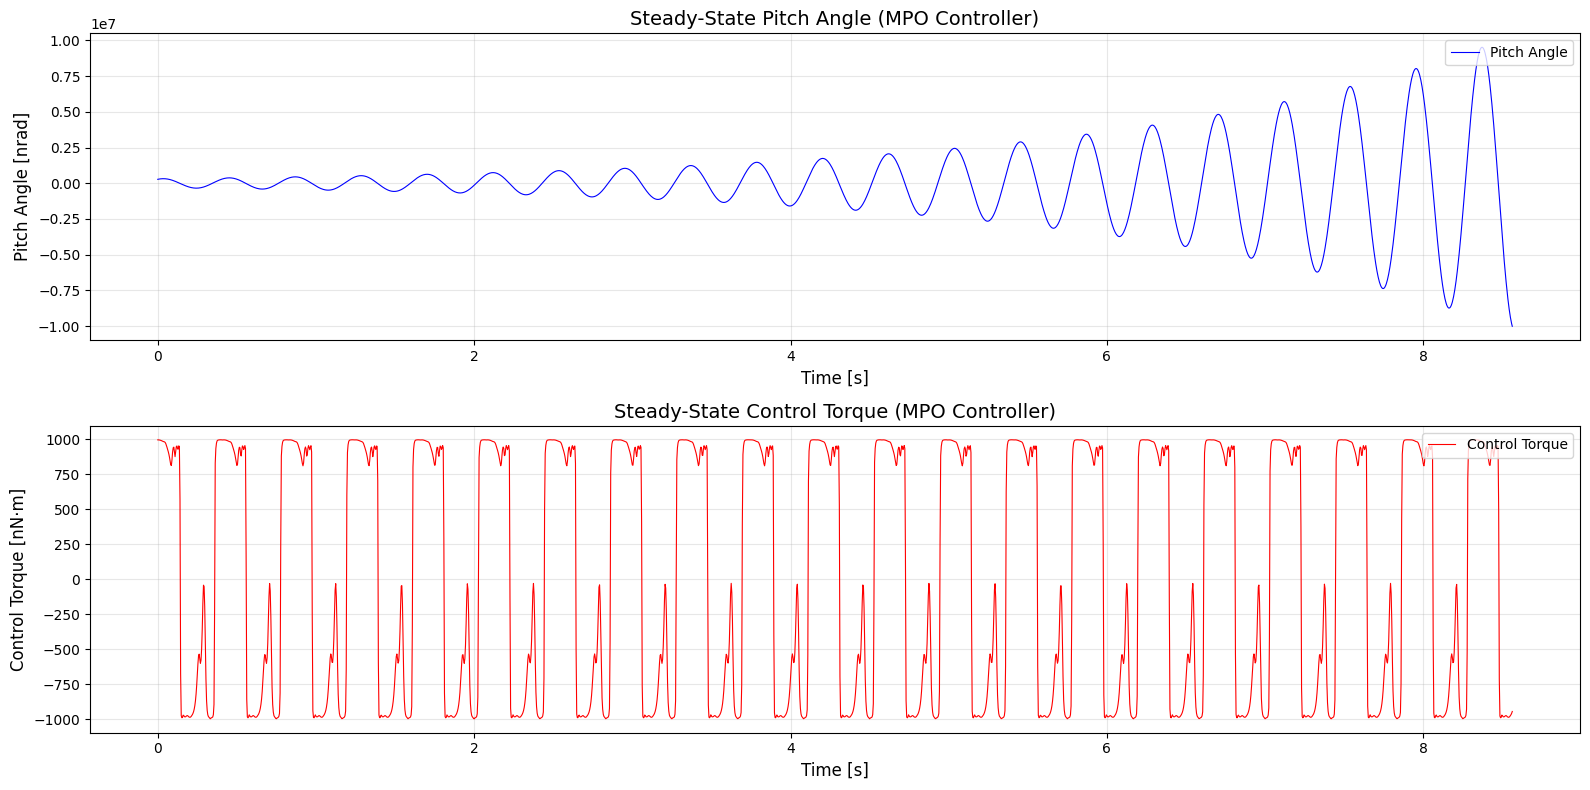


Time-series plots saved to 'mpo_controller_timeseries.png'

SUMMARY: Deep Loop Shaping MPO Controller

This notebook trained a Maximum a Posteriori Policy Optimization (MPO) controller
for LIGO pitch stabilization using frequency-selective reward shaping:

1. ALGORITHM: MPO with EM-style policy updates
   - E-step: Compute non-parametric policy from Q-values with temperature η
   - M-step: Fit parametric policy with KL constraint (α penalty)
   - Dual optimization automatically tunes η and α

2. PLANT MODEL: Discrete-time state-space with unstable radiation pressure pole

3. OBSERVATIONS: Time-domain only (pitch angle + short history)
   - No frequency filtering in observation space

4. REWARD: Multiplicative sigmoid scores from three Butterworth-filtered bands
   - Low (<3 Hz): Stability constraint
   - Mid (8-30 Hz): Noise suppression
   - High (>40 Hz): Robustness margin

5. OUTPUT: Physical control torque (N·m)
   - No action penalty or filtering

MPO's KL-constrained updates prov

In [31]:
# =============================================================================
# Time-Domain Visualization (Steady State)
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Use first 10 seconds of steady-state data
n_plot = min(int(10 * fs), len(eval_results['t']))
t_plot = eval_results['t'][:n_plot] - eval_results['t'][0]

# --- Top: Pitch Angle ---
ax1 = axes[0]
ax1.plot(t_plot, eval_results['pitch_rad'][:n_plot] * 1e9, 'b-', 
         linewidth=0.8, label='Pitch Angle')
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Pitch Angle [nrad]', fontsize=12)
ax1.set_title('Steady-State Pitch Angle (MPO Controller)', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- Bottom: Control Torque ---
ax2 = axes[1]
ax2.plot(t_plot, eval_results['torque_Nm'][:n_plot] * 1e9, 'r-', 
         linewidth=0.8, label='Control Torque')
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Control Torque [nN·m]', fontsize=12)
ax2.set_title('Steady-State Control Torque (MPO Controller)', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mpo_controller_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTime-series plots saved to 'mpo_controller_timeseries.png'")

# =============================================================================
# Summary
# =============================================================================
print("\n" + "=" * 70)
print("SUMMARY: Deep Loop Shaping MPO Controller")
print("=" * 70)
print("""
This notebook trained a Maximum a Posteriori Policy Optimization (MPO) controller
for LIGO pitch stabilization using frequency-selective reward shaping:

1. ALGORITHM: MPO with EM-style policy updates
   - E-step: Compute non-parametric policy from Q-values with temperature η
   - M-step: Fit parametric policy with KL constraint (α penalty)
   - Dual optimization automatically tunes η and α

2. PLANT MODEL: Discrete-time state-space with unstable radiation pressure pole
   
3. OBSERVATIONS: Time-domain only (pitch angle + short history)
   - No frequency filtering in observation space
   
4. REWARD: Multiplicative sigmoid scores from three Butterworth-filtered bands
   - Low (<3 Hz): Stability constraint
   - Mid (8-30 Hz): Noise suppression
   - High (>40 Hz): Robustness margin
   
5. OUTPUT: Physical control torque (N·m)
   - No action penalty or filtering

MPO's KL-constrained updates provide stable policy improvement, making it
well-suited for this safety-critical control task.
""")
print("=" * 70)